## PCA and SVM analysis

In [1]:
library(factoextra)
library(ggplot2)
library(dplyr)
library(caret)

Warning message:
"package 'factoextra' was built under R version 3.2.5"Loading required package: ggplot2
Warning message:
"package 'ggplot2' was built under R version 3.2.5"Warning message:
"package 'dplyr' was built under R version 3.2.5"
Attaching package: 'dplyr'

The following objects are masked from 'package:stats':

    filter, lag

The following objects are masked from 'package:base':

    intersect, setdiff, setequal, union

Warning message:
"package 'caret' was built under R version 3.2.5"Loading required package: lattice
Warning message:
"package 'lattice' was built under R version 3.2.5"

ERROR: Error: package or namespace load failed for 'caret'


In [2]:
# load dataset
df<- read.csv('TOTALDF.csv', header = T)
df<- df %>%
mutate(GR_Activity = ifelse(PreExposure == 'Vehicle', 0,
                           ifelse(PreExposure == 'DEX', 1,
                                 ifelse(PreExposure == 'CORT' & (Antagonist =='Vehicle'| Antagonist == 'Spironolactone'| Antagonist == 'None'), 1, 0)))) %>%
mutate(MR_Activity = ifelse(PreExposure == 'Vehicle', 0,
                           ifelse(PreExposure == 'DEX', 0,
                                 ifelse(PreExposure == 'CORT' & (Antagonist =='Vehicle'| Antagonist == 'Mifepristone'| Antagonist == 'None'), 1, 0)))) %>%
mutate(Receptor_activity = ifelse(GR_Activity == 0 & MR_Activity == 0, 'None', 
                                 ifelse(GR_Activity == 1 & MR_Activity == 0, 'GR only',
                                       ifelse(GR_Activity == 0 & MR_Activity == 1, 'MR only',
                                               'GR + MR'))))

df$Receptor_activity<- as.factor(df$Receptor_activity)
df$Receptor_activity<- factor(df$Receptor_activity, levels = c('None', 'GR + MR', 'GR only', 'MR only'))

## PCA for visualising multiple measures

In [3]:
pc <- prcomp(df[5:11], scale = T)
eig<- pc$sdev^2
variance <- eig*100/sum(eig)
cumvar <- cumsum(variance)
eiganvals<-data.frame(eig = eig, variance =variance, cumvar=cumvar)
eiganvals

eig,variance,cumvar
2.2193378,31.704825,31.70483
1.9960063,28.514376,60.21920
0.9400457,13.429225,73.64843
0.7647138,10.924483,84.57291
0.4847226,6.924608,91.49752
0.4409275,6.298965,97.79648
0.1542463,2.203518,100.00000


In [4]:
pc$rotation #identify the transformation parameter for each variable according to PC dimensions

,PC1,PC2,PC3,PC4,PC5,PC6,PC7
BetaActin,0.57436993,-0.13029744,0.1435007,0.42990607,0.08155303,0.08361614,-0.65883801
HMGB1,0.61809899,-0.05059051,0.1804951,0.16998934,0.15368069,0.06004687,0.72573823
ASC,0.43718431,0.12820054,0.2149986,-0.72566737,-0.37818065,-0.23421558,-0.14744292
NLRP3,-0.28487391,-0.06675486,0.9038147,-0.01957537,0.01063423,0.31130143,-0.01023840
LDH,-0.06790400,0.53660946,0.1793762,0.48942680,-0.50556867,-0.41726245,0.07757109
CellViability,-0.10498703,-0.57817874,0.1886178,0.05302513,0.15648902,-0.76902468,0.02027162
SupernatantViability,0.01167618,0.58080222,0.1263770,-0.13022221,0.73926258,-0.26857082,-0.10470931


Importance of components:
                         PC1    PC2    PC3    PC4     PC5     PC6     PC7
Standard deviation     1.490 1.4128 0.9696 0.8745 0.69622 0.66402 0.39274
Proportion of Variance 0.317 0.2851 0.1343 0.1092 0.06925 0.06299 0.02204
Cumulative Proportion  0.317 0.6022 0.7365 0.8457 0.91498 0.97796 1.00000

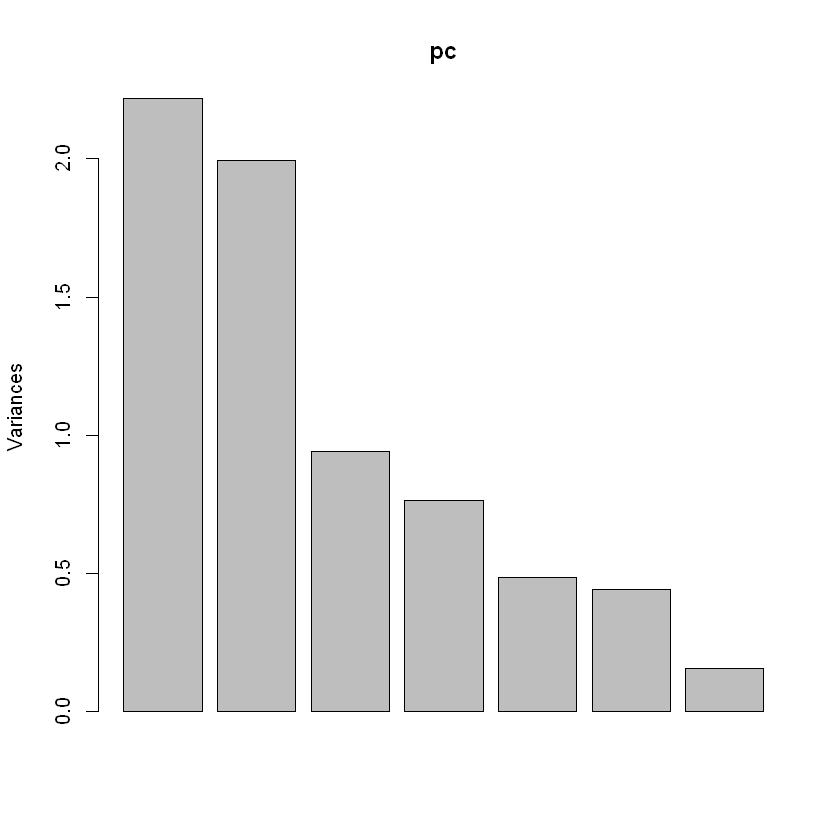

In [5]:
summary(pc)
screeplot(pc) # visulaises varibility captured

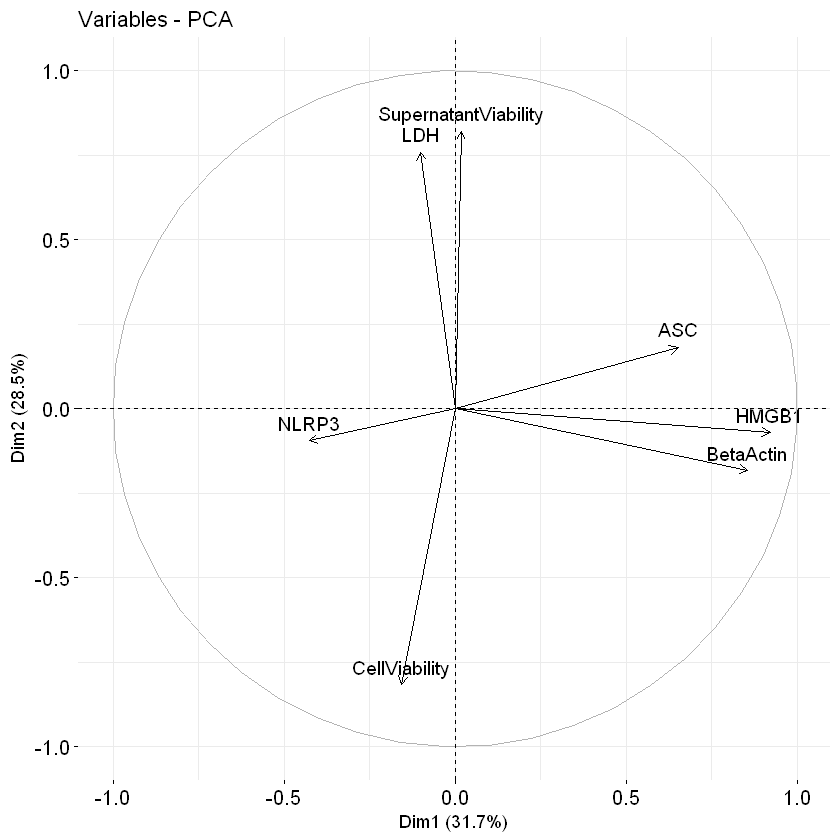

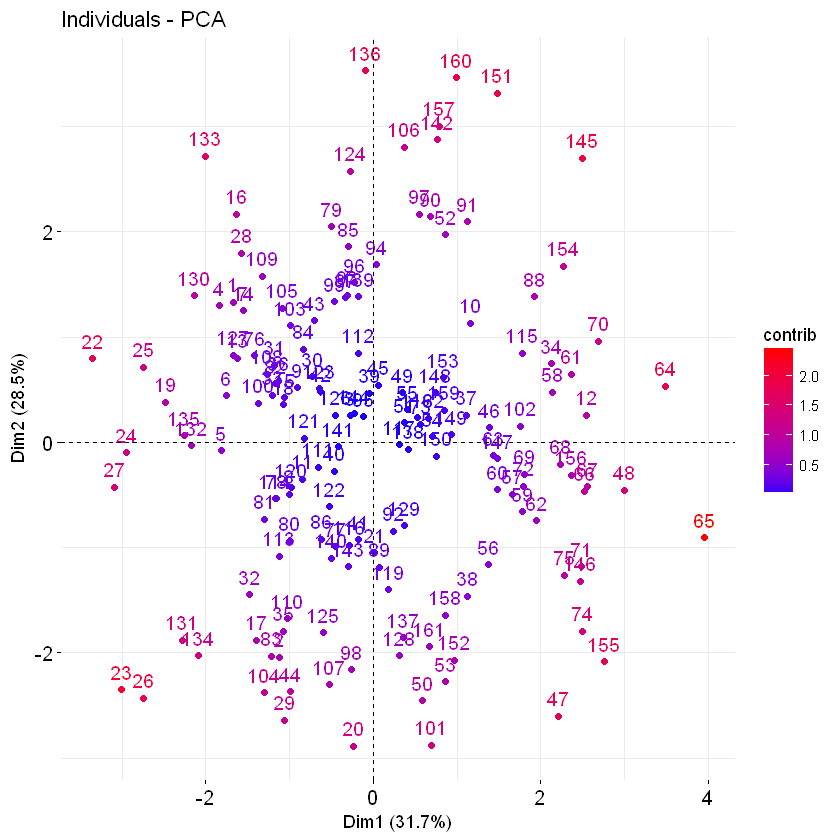

In [5]:
fviz_pca_var(pc) # principal component directions and weights
fviz_pca_ind(pc, col.ind='contrib')+
      scale_color_gradient2(low="black", mid="blue",
      high="red")

In [6]:
groups <- cbind(df[1:4], df[12:14])
rotateddf<- data.frame(groups, pc$x) #use rotation from PCA transformation on original data points
newvar<-get_pca_var(pc)
newvar
coordinates<- data.frame(varnames= rownames(newvar$coord), newvar$coord) #variable data
data_split #variable coordinates according to 

Principal Component Analysis Results for variables
  Name       Description                                    
1 "$coord"   "Coordinates for the variables"                
2 "$cor"     "Correlations between variables and dimensions"
3 "$cos2"    "Cos2 for the variables"                       
4 "$contrib" "contributions of the variables"               

,varnames,Dim.1,Dim.2,Dim.3,Dim.4,Dim.5,Dim.6,Dim.7
BetaActin,BetaActin,0.85566427,-0.18408433,0.1391325,0.37594391,0.056778865,0.05552310,-0.258753340
HMGB1,HMGB1,0.92080938,-0.07147432,0.1750008,0.14865214,0.106995598,0.03987255,0.285027867
ASC,ASC,0.65129278,0.18112183,0.2084540,-0.63458100,-0.263297008,-0.15552470,-0.057907025
NLRP3,NLRP3,-0.42438925,-0.09431132,0.8763022,-0.01711825,0.007403769,0.20671154,-0.004021048
LDH,LDH,-0.10115959,0.75812232,0.1739159,0.42799354,-0.351987121,-0.27707217,0.030465425
CellViability,CellViability,-0.15640382,-0.81685143,0.1828762,0.04636937,0.108950814,-0.51065064,0.007961518
SupernatantViability,SupernatantViability,0.01739452,0.82055788,0.1225300,-0.11387661,0.514689536,-0.17833740,-0.041123739


In [7]:
# preparing data frame for plotting
rotateddf$Treatment<- factor(rotateddf$Treatment, levels = c('None', 'Vehicle', 'LPS'))
rotateddf$Antagonist<- factor(rotateddf$Antagonist, levels = c('None', 'Vehicle', 'Mifepristone', 'Spironolactone'))
rotateddf$Receptor_activity <- factor(rotateddf$Receptor_activity, levels = c('None', 'GR + MR','GR only','MR only'))

none_only<- rotateddf %>%
filter(Receptor_activity =='None')

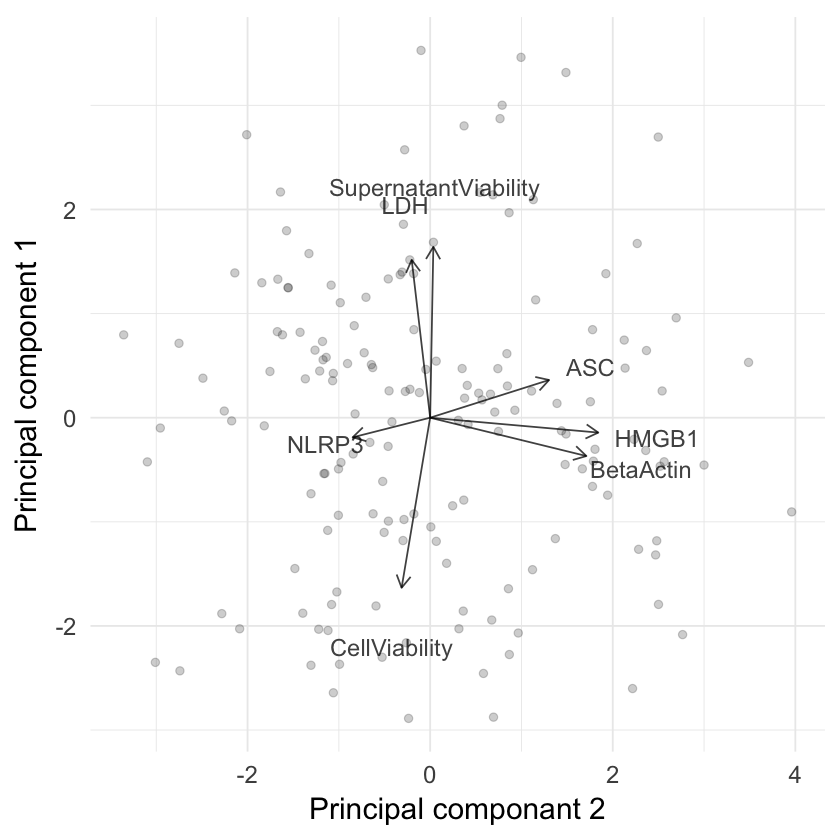

In [151]:
#Plot all datapoints on PC1 and PC2
plot16<- ggplot(data = rotateddf, aes(x = PC1, y = PC2))+
geom_point(size = 2, alpha = 0.2)+
geom_segment(data = coordinates, aes(x = 0, y = 0, xend = Dim.1*2, yend = Dim.2*2), 
             arrow = arrow(length = unit(0.3, 'cm')), alpha = 0.75, color = 'black')+
geom_text(data=coordinates, aes(x=Dim.1*2.7, y=Dim.2*2.7, label=varnames), size = 5, color="black", alpha = 0.75)+
theme_minimal(base_size = 18)+
labs(y = 'Principal component 1', x = 'Principal componant 2')+
theme(aspect.ratio = 1, legend.position = 'none')

plot16

In [23]:
ggsave(plot17, filename = 'pcaplot_palette.png')

Saving 6.67 x 6.67 in image


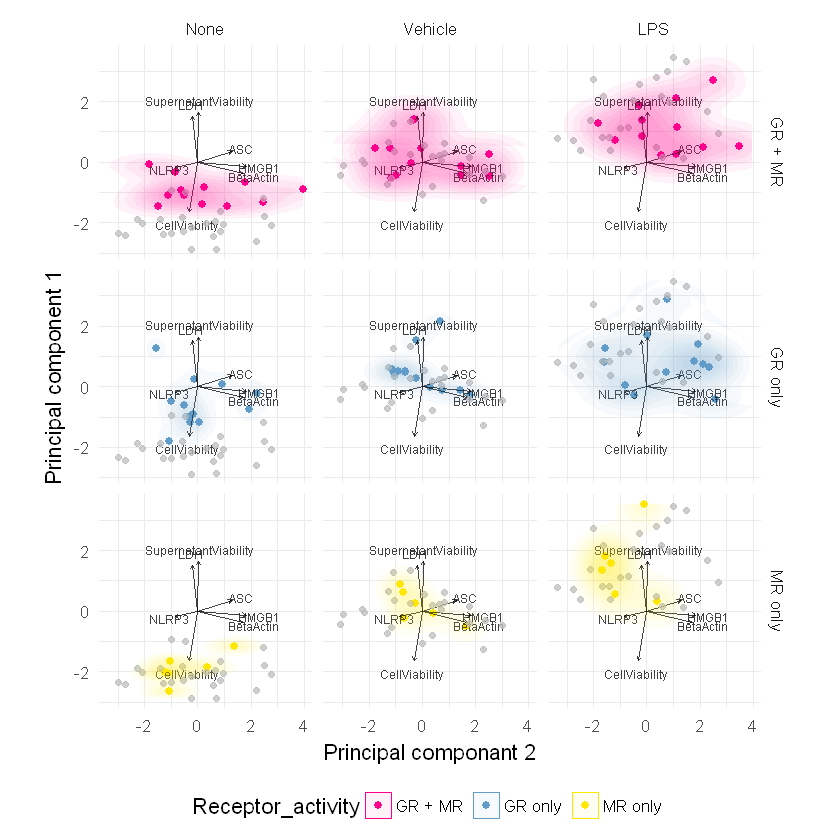

In [21]:
# split plots intop different subgroups according to receptor activity and treatments
plot17<- ggplot(data = filter(rotateddf, Receptor_activity != 'None'), aes(x = PC1, y = PC2))+
facet_grid(Receptor_activity~Treatment)+
geom_point(aes(colour = Receptor_activity), size = 2)+
geom_segment(data = coordinates, aes(x = 0, y = 0, xend = Dim.1*2, yend = Dim.2*2), 
             arrow = arrow(length = unit(0.1, 'cm')), alpha = 0.75, color = 'black')+
geom_text(data=coordinates, aes(x=Dim.1*2.5, y=Dim.2*2.5, label=varnames), size = 2.5, color="black", alpha = 0.75)+
geom_point(data = none_only[, c('Treatment','PC1', 'PC2')], aes(y = PC2, x = PC1), colour = 'grey', alpha = 0.75)+
stat_density2d(geom = 'polygon', aes(fill = Receptor_activity), alpha = 0.05)+
theme_minimal(base_size = 13)+
labs(y = 'Principal component 1', x = 'Principal componant 2')+
theme(aspect.ratio = 1, legend.position = 'bottom')+
scale_color_manual(values = palette)+
scale_fill_manual(values = palette)

plot17

PCA with feature scaling on dataset separated by GR / MR receptor activity: 

    - Grey dots represent no GR or MR activity (vehicle pre-exposure) 
    - Supporting Linear model findings, most differences in receptor activity appear to be beforer addition of a further 24h treatment of either vehicle or LPS
    - MR only (GR antagonist) appears to be least different from no receptor activity 
    - GR only (MR antagonist, DEX treatment) and GR + MR activity (CORT with no antagonist) seem to separate from no receptor activity. 
    

# Multinomial logistic regression

- Predicting Receptor activity from available measures using logistic regression

In [154]:
library(nnet)

In [255]:
model<-  multinom(Receptor_activity ~ PC1 + PC2 + Treatment , data = rotateddf)
summary(model)

# weights:  24 (15 variable)
initial  value 224.579687 
iter  10 value 199.576296
final  value 199.270979 
converged


Call:
multinom(formula = Receptor_activity ~ PC1 + PC2 + Treatment, 
    data = rotateddf)

Coefficients:
        (Intercept)        PC1       PC2 TreatmentVehicle TreatmentLPS
GR + MR -0.01982778  0.2744703 0.4665005       -0.7639453   -1.2946938
GR only  0.21504123  0.2121734 0.6387951       -1.0306102   -1.7738566
MR only -1.18411884 -0.1391956 0.1571775       -0.2590526   -0.4283374

Std. Errors:
        (Intercept)       PC1       PC2 TreatmentVehicle TreatmentLPS
GR + MR   0.5149143 0.1432792 0.2543237        0.6518814    0.8649044
GR only   0.5028788 0.1456730 0.2526202        0.6491301    0.8686690
MR only   0.7093064 0.1866146 0.3400152        0.8725768    1.1321909

Residual Deviance: 398.542 
AIC: 428.542 

In [256]:
cm<-  table(predict(model), rotateddf$Receptor_activity)
confusionMatrix(cm)

Confusion Matrix and Statistics

         
          None GR + MR GR only MR only
  None      65      29      28      17
  GR + MR    2       3       1       0
  GR only    5       4       7       1
  MR only    0       0       0       0

Overall Statistics
                                          
               Accuracy : 0.463           
                 95% CI : (0.3844, 0.5429)
    No Information Rate : 0.4444          
    P-Value [Acc > NIR] : 0.3455          
                                          
                  Kappa : 0.0853          
 Mcnemar's Test P-Value : NA              

Statistics by Class:

                     Class: None Class: GR + MR Class: GR only Class: MR only
Sensitivity               0.9028        0.08333        0.19444         0.0000
Specificity               0.1778        0.97619        0.92063         1.0000
Pos Pred Value            0.4676        0.50000        0.41176            NaN
Neg Pred Value            0.6957        0.78846        0.80000 

# SVM only on treatment == 'None' 

- Since most antagonist differences are only seen prior to further 24h treatment with Vehicle / LPS, can better classification be achieved if we just look at prior treatments? 

In [7]:
library(e1071) # for svm() function

Warning message:
"package 'e1071' was built under R version 3.2.5"

In [165]:
df3<- filter(df, Treatment == 'None')
df2<- as.matrix( df3 %>%  select(BetaActin, HMGB1, CellViability, SupernatantViability, LDH) %>% 
                mutate_each(funs(scale)))
df2<- data.frame(Receptor_activity = df3$Receptor_activity, df2)


In [166]:
summary(df2)

 Receptor_activity   BetaActin           HMGB1         CellViability    
 None   :24        Min.   :-1.4839   Min.   :-1.1889   Min.   :-2.3165  
 GR + MR:12        1st Qu.:-0.6950   1st Qu.:-0.8032   1st Qu.:-0.8362  
 GR only:12        Median :-0.2715   Median :-0.2723   Median : 0.2122  
 MR only: 6        Mean   : 0.0000   Mean   : 0.0000   Mean   : 0.0000  
                   3rd Qu.: 0.5389   3rd Qu.: 0.5966   3rd Qu.: 0.7032  
                   Max.   : 2.9680   Max.   : 2.4437   Max.   : 1.7842  
 SupernatantViability      LDH         
 Min.   :-1.47137     Min.   :-1.2127  
 1st Qu.:-0.81134     1st Qu.:-0.6810  
 Median :-0.06459     Median :-0.3222  
 Mean   : 0.00000     Mean   : 0.0000  
 3rd Qu.: 0.77369     3rd Qu.: 0.3964  
 Max.   : 2.44062     Max.   : 3.5905  

In [167]:
svm1<- svm(Receptor_activity ~ BetaActin+HMGB1+ CellViability+ SupernatantViability+LDH, data =df2, kernel = 'radial')
summary(svm1)


Call:
svm(formula = Receptor_activity ~ BetaActin + HMGB1 + CellViability + 
    SupernatantViability + LDH, data = df2, kernel = "radial")


Parameters:
   SVM-Type:  C-classification 
 SVM-Kernel:  radial 
       cost:  1 
      gamma:  0.2 

Number of Support Vectors:  50

 ( 6 12 12 20 )


Number of Classes:  4 

Levels: 
 None GR + MR GR only MR only




In [168]:
table(predicted = predict(svm1), actual = df2$Receptor_activity) # confusion matrix 

         actual
predicted None GR + MR GR only MR only
  None      24       2       1       6
  GR + MR    0       8       1       0
  GR only    0       2      10       0
  MR only    0       0       0       0

# PCA for visualising SVM analysis

In [170]:
pca1<- prcomp(df2[2:6])
pca1$rotation

,PC1,PC2,PC3,PC4,PC5
BetaActin,0.56582377,-0.2888225,0.3401929,-0.2991229,-0.6254753
HMGB1,0.54947026,-0.3473719,0.2511035,0.3404935,0.6312102
CellViability,-0.01991994,0.6339167,0.7307309,-0.1828959,0.1741672
SupernatantViability,-0.47853121,-0.3436935,0.4953538,0.5740266,-0.2792861
LDH,-0.38540494,-0.5252986,0.2046283,-0.6569872,0.3194048


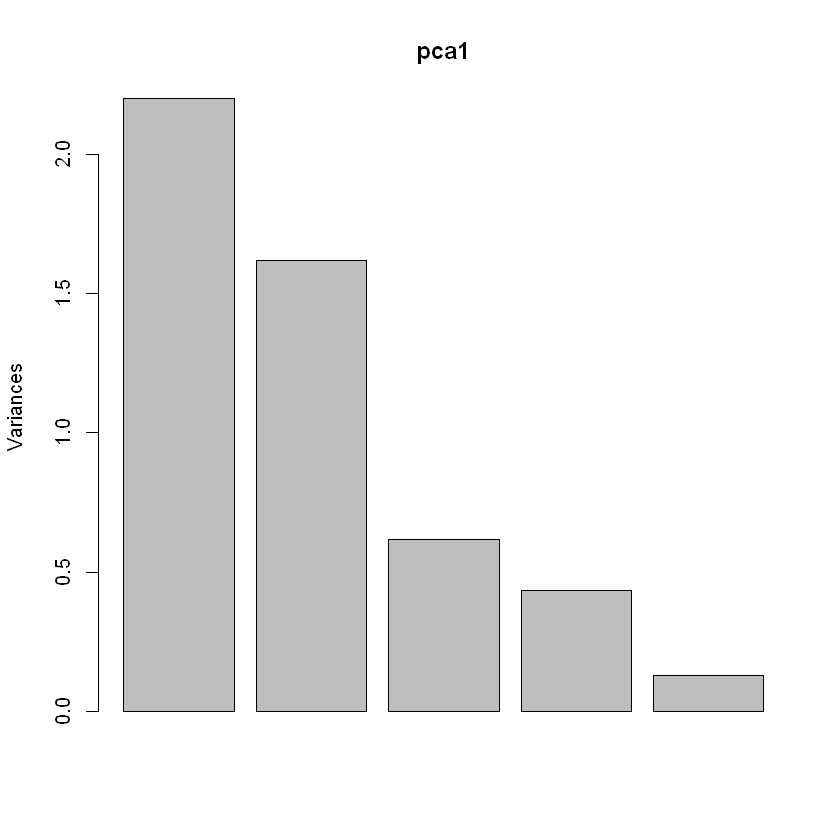

In [171]:
screeplot(pca1)

In [172]:
# To show cassification boundaries, project classification predictions using a regular grid of values
# Note: Computationally expensive depending on grid size of each variable
# Test data is just a grid of values to predict
testData<- expand.grid(BetaActin= seq(min(df2[,2]-.5), max(df2[,2]+.5), by = 0.35),
                             HMGB1= seq(min(df2[,3]-.5), max(df2[,3]+.5), by = 0.35),
                      CellViability = seq(min(df2[,4]-.5), max(df2[,4]+.5), by =0.35),
                      SupernatantViability = seq(min(df2[,5]-.5), max(df2[,5]+.5), by =0.35),
                      LDH= seq(min(df2[,6],-.5), max(df2[,6], +.5), by=0.35))

In [173]:
predicted <- predict(svm1, testData) # Predict classification using testData

In [174]:
testData<- data.frame(predicted, testData) #format into data frame

In [175]:
traindata<-data.frame(pca1$x, df3[,2:4], df3[14]) # rotate predicted values using same PCA transformation

In [176]:
summary(testData)

   predicted        BetaActin           HMGB1         CellViability    
 None   :403158   Min.   :-1.9839   Min.   :-1.6889   Min.   :-2.8165  
 GR + MR:137169   1st Qu.:-0.6714   1st Qu.:-0.6389   1st Qu.:-1.7665  
 GR only:165273   Median : 0.6411   Median : 0.5861   Median :-0.3665  
 MR only:     0   Mean   : 0.6411   Mean   : 0.5861   Mean   :-0.3665  
                  3rd Qu.: 1.9536   3rd Qu.: 1.8111   3rd Qu.: 1.0335  
                  Max.   : 3.2661   Max.   : 2.8611   Max.   : 2.0835  
 SupernatantViability      LDH         
 Min.   :-1.9714      Min.   :-1.2127  
 1st Qu.:-0.9214      1st Qu.:-0.1627  
 Median : 0.4786      Median : 1.0623  
 Mean   : 0.4786      Mean   : 1.0623  
 3rd Qu.: 1.8786      3rd Qu.: 2.2873  
 Max.   : 2.9286      Max.   : 3.3373  

In [177]:
rotatedpred<- scale(testData[2:6], pca1$center, pca1$scale) %*% pca1$rotation

In [178]:
rotatedpred<- data.frame(predicted, rotatedpred)

In [179]:
summary(rotatedpred)

   predicted           PC1                PC2               PC3         
 None   :403158   Min.   :-4.77967   Min.   :-6.4822   Min.   :-4.3818  
 GR + MR:137169   1st Qu.:-0.99930   1st Qu.:-2.3841   1st Qu.:-0.5316  
 GR only:165273   Median : 0.05366   Median :-1.3436   Median : 0.5519  
 MR only:     0   Mean   : 0.05366   Mean   :-1.3436   Mean   : 0.5519  
                  3rd Qu.: 1.10662   3rd Qu.:-0.3032   3rd Qu.: 1.6354  
                  Max.   : 4.88699   Max.   : 3.7950   Max.   : 5.4856  
      PC4               PC5         
 Min.   :-5.2573   Min.   :-4.8048  
 1st Qu.:-1.3814   1st Qu.:-0.9539  
 Median :-0.3483   Median : 0.1107  
 Mean   :-0.3483   Mean   : 0.1107  
 3rd Qu.: 0.6848   3rd Qu.: 1.1753  
 Max.   : 4.5606   Max.   : 5.0262  

In [180]:
newvar<-get_pca_var(pca1)
newvar
coordinates<- data.frame(varnames= rownames(newvar$coord), newvar$coord) #variable data
coordinates #variable coordinates

Principal Component Analysis Results for variables
  Name       Description                                    
1 "$coord"   "Coordinates for the variables"                
2 "$cor"     "Correlations between variables and dimensions"
3 "$cos2"    "Cos2 for the variables"                       
4 "$contrib" "contributions of the variables"               

,varnames,Dim.1,Dim.2,Dim.3,Dim.4,Dim.5
BetaActin,BetaActin,0.83927052,-0.3674415,0.2675613,-0.1972124,-0.22389712
HMGB1,HMGB1,0.81501382,-0.4419285,0.1974926,0.2244882,0.22595002
CellViability,CellViability,-0.02954669,0.8064724,0.5747190,-0.1205837,0.06234543
SupernatantViability,SupernatantViability,-0.70979191,-0.4372487,0.3895952,0.3784570,-0.09997414
LDH,LDH,-0.57166034,-0.6682878,0.1609399,-0.4331532,0.11433515


In [9]:
palette <- c('#ff008d', '#619bc7', '#ffe700', '#545454')

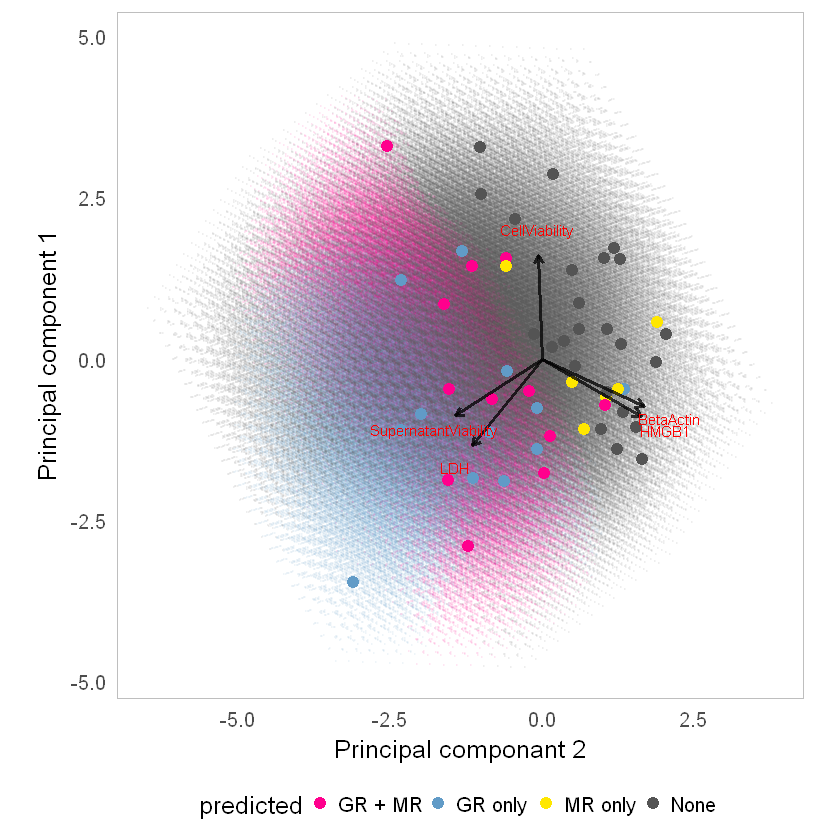

In [190]:
#Plot training and predicted data
svmPCAplot<-ggplot(data = as.data.frame(rotatedpred), aes(y= PC1, x = PC2, colour = predicted))+ #predicted  data
geom_point(size = 0.01, alpha = 0.05)+
geom_point(data = traindata, aes(y = PC1, x = PC2, colour = Receptor_activity), size = 3)+ # training data
geom_segment(data = coordinates, aes(x = 0, y = 0, xend = Dim.1*2, yend = Dim.2*2), 
             arrow = arrow(length = unit(0.2, 'cm')), alpha = 0.75, color = 'black', size = 1)+
geom_text(data=coordinates, aes(x=Dim.1*2.5, y=Dim.2*2.5, label=varnames), size = 3.2, color="red")+
theme_minimal(base_size = 15)+
labs(y = 'Principal component 1', x = 'Principal componant 2')+
theme(aspect.ratio= 1, legend.position = 'bottom', panel.grid.major = element_blank(), panel.grid.minor = element_blank(),
     panel.background = element_blank(), panel.border = element_rect(fill =NA, colour = 'grey'))+
scale_color_manual(values = palette)

svmPCAplot

In [191]:
ggsave(svmPCAplot, filename = 'svmpcaplot.png')

Saving 6.67 x 6.67 in image


# Verifying results

Double checking results using random (shuffled) data is a good way to check if model is informative

In [20]:
# what happens when you shuffle the dataset? Better than chance?

randomised<- rotateddf %>%
filter(Treatment =='None') %>%
mutate(Receptor_activity = sample(Receptor_activity))

head(randomised)
table(Predicted = predict(model_svm), Random = randomised$Receptor_activity)

N,PreExposure,Antagonist,Treatment,GR_Activity,MR_Activity,Receptor_activity,PC1,PC2,PC3,PC4,PC5,PC6,PC7
1,CORT,Mifepristone,None,0,1,None,-1.118724,-2.04361304,-0.8161793,0.5289358,0.4187971,-1.0270836,-0.3197676
1,CORT,None,None,1,1,None,-1.817116,-0.07813036,-1.2235422,0.5531826,-0.5635119,-0.4722392,0.1467721
1,CORT,Spironolactone,None,1,0,GR only,-1.003738,-0.49212280,-0.3570983,0.4711058,-0.4775010,-0.2372164,-0.6335899
1,CORT,Vehicle,None,1,1,GR only,-0.843290,-0.34861355,-1.0303080,1.0081811,-0.3008782,-0.2731067,-0.1859407
1,DEX,None,None,1,0,GR only,-1.553970,1.24721457,-1.3521458,0.9757084,-1.1492944,0.3469019,0.0801271
1,Vehicle,Mifepristone,None,0,0,GR only,-1.394942,-1.87777827,-0.8001333,0.2349291,0.3281574,-0.9227034,-0.3548694


         Random
Predicted None GR + MR GR only MR only
  None      15       6       6       4
  GR + MR    7       2       1       2
  GR only    2       4       5       0
  MR only    0       0       0       0

In [21]:
#Actual
confusionMatrix(table(Predicted = predict(model_svm), actual = filter(rotateddf, Treatment == 'None')$Receptor_activity))
#Shuffled
confusionMatrix(table(Predicted = predict(model_svm), Random = randomised$Receptor_activity))


Confusion Matrix and Statistics

         actual
Predicted None GR + MR GR only MR only
  None      22       3       1       5
  GR + MR    2       8       1       1
  GR only    0       1      10       0
  MR only    0       0       0       0

Overall Statistics
                                          
               Accuracy : 0.7407          
                 95% CI : (0.6035, 0.8504)
    No Information Rate : 0.4444          
    P-Value [Acc > NIR] : 9.628e-06       
                                          
                  Kappa : 0.6013          
 Mcnemar's Test P-Value : NA              

Statistics by Class:

                     Class: None Class: GR + MR Class: GR only Class: MR only
Sensitivity               0.9167         0.6667         0.8333         0.0000
Specificity               0.7000         0.9048         0.9762         1.0000
Pos Pred Value            0.7097         0.6667         0.9091            NaN
Neg Pred Value            0.9130         0.9048         0

Confusion Matrix and Statistics

         Random
Predicted None GR + MR GR only MR only
  None      15       6       6       4
  GR + MR    7       2       1       2
  GR only    2       4       5       0
  MR only    0       0       0       0

Overall Statistics
                                          
               Accuracy : 0.4074          
                 95% CI : (0.2757, 0.5497)
    No Information Rate : 0.4444          
    P-Value [Acc > NIR] : 0.7522          
                                          
                  Kappa : 0.0886          
 Mcnemar's Test P-Value : NA              

Statistics by Class:

                     Class: None Class: GR + MR Class: GR only Class: MR only
Sensitivity               0.6250        0.16667        0.41667         0.0000
Specificity               0.4667        0.76190        0.85714         1.0000
Pos Pred Value            0.4839        0.16667        0.45455            NaN
Neg Pred Value            0.6087        0.76190        0.

Summary: 

    - Overall accuracy is better than before (57%)
    - Some discrimination between GR + MR and GR only class (low sensitivity but high-ish specificity)
    - balanced accuracy is also improved
    - Could this be over-fitting? 